In [ ]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
img=Image.open('BSDS_361010.jpg')

feature_extractor=DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model=DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

inputs=feature_extractor(img,return_tensors='pt')
res=model(**inputs)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


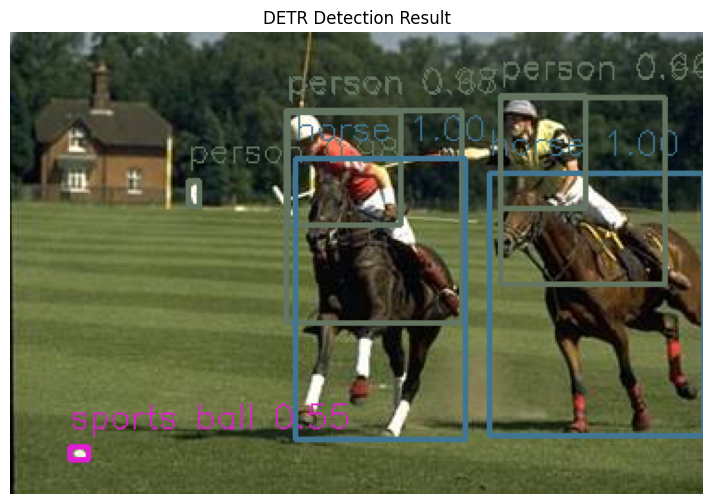

In [ ]:
# PIL 이미지 → np 배열 + RGB → BGR (OpenCV용)
im = np.array(img.convert("RGB"))
H, W = im.shape[:2]
im = cv.cvtColor(im, cv.COLOR_RGB2BGR)

colors = np.random.uniform(0, 255, size=(100, 3))

for i in range(res.logits.shape[1]):
    predicted_label = res.logits[0, i].argmax(-1).item()
    if predicted_label != 91:  # 91 = __background__
        name = model.config.id2label[predicted_label]
        prob = float(res.logits[0, i].softmax(dim=0)[predicted_label])
        label = f"{name} {prob:.2f}"

        # DETR boxes are [cx, cy, w, h] in normalized format (0~1)
        box = res.pred_boxes[0, i].cpu().detach().numpy()
        cx, cy, w, h = box
        x1 = int((cx - w/2) * W)
        y1 = int((cy - h/2) * H)
        x2 = int((cx + w/2) * W)
        y2 = int((cy + h/2) * H)

        color = tuple(map(int, colors[predicted_label]))
        cv.rectangle(im, (x1, y1), (x2, y2), color, 2)
        cv.putText(im, label, (x1, max(y1 - 10, 0)), cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 1)

# BGR → RGB (for matplotlib)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(im_rgb)
plt.axis('off')
plt.title("DETR Detection Result")
plt.show()
